# Model Training and Evaluation

In this notebook, we experiment with various machine learning models using autoML tools, select one model, fine tune its parameters, optimize the threshold, evaluate the model using classic performance metrics and using domain metrics, and save the model. Here, we also explore the feature importance.

In [14]:
import os
import sys
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import confusion_matrix

import joblib

In [15]:
modules_path = os.path.join(os.getcwd(), "../modules")
if modules_path not in sys.path:
    sys.path.append(modules_path)
from data_preprocessing_training import data_preprocessing_training

## Import data

In [16]:
data_path = os.path.join(os.getcwd(), "../data")
df = pd.read_csv(
    os.path.join(
        data_path, "data_extracted", "bank-additional", "bank-additional-full.csv"
    ),
    delimiter=";",
)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Train a Random Forest model

Ideally, we would test many different algorithms and select the one that performs the best. This process could be speeded up by tools like AutoML. However, in the scope of this project, we train a model using an Random Forest algorithm. It is known to generalize better than a single decision tree and provides embedded feature importance which can be useful for the stakeholders.

We start with preparing the data to train an Random Forest model.

### Data pre-processing

In [17]:
required_features = [
    "age",
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]

tr_x, tr_y, val_x, val_y, test_x, test_y = data_preprocessing_training(df, 'y', required_features)

print("Training Features Shape:", tr_x.shape)
print("Training Labels Shape:", tr_y.shape)
print("Testing Features Shape:", test_x.shape)
print("Testing Labels Shape:", test_y.shape)
print("Validation Features Shape:", val_x.shape)
print("Validation Labels Shape:", val_y.shape)

Training Features Shape: (33362, 597)
Training Labels Shape: (33362,)
Testing Features Shape: (4119, 597)
Testing Labels Shape: (4119,)
Validation Features Shape: (3707, 597)
Validation Labels Shape: (3707,)


/Users/ladarudnitckaia/opt/anaconda3/envs/telemarketing-optimization/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ladarudnitckaia/opt/anaconda3/envs/telemarketing-optimization/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


### Model training

First, we define the classifier and a set of possible hyperparameters for tuning. Then, we train a Random Forest model several times with different hyperparameters using the Random Search (to speed up the process). The evaluation is based on the 5 fold cross validation and Recall metric.

In [18]:
rf_classifier = RandomForestClassifier(
    class_weight="balanced", bootstrap=True, random_state=42
)
# The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies

In [19]:
hyperparams = {
    "n_estimators": [100, 500],
    "max_depth": [10, 20],
    "min_samples_leaf": [2, 3],
}
recall_scorer = make_scorer(recall_score, average="binary")

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=hyperparams,
    cv=cv,
    scoring=recall_scorer,
    verbose=4,
)
random_search.fit(tr_x, tr_y)

/Users/ladarudnitckaia/opt/anaconda3/envs/telemarketing-optimization/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_depth=10, min_samples_leaf=2, n_estimators=100;, score=0.642 total time=   3.3s
[CV 2/5] END max_depth=10, min_samples_leaf=2, n_estimators=100;, score=0.668 total time=   2.1s
[CV 3/5] END max_depth=10, min_samples_leaf=2, n_estimators=100;, score=0.655 total time=   2.6s
[CV 4/5] END max_depth=10, min_samples_leaf=2, n_estimators=100;, score=0.634 total time=   3.4s
[CV 5/5] END max_depth=10, min_samples_leaf=2, n_estimators=100;, score=0.686 total time=   3.4s
[CV 1/5] END max_depth=10, min_samples_leaf=2, n_estimators=500;, score=0.644 total time=  17.4s
[CV 2/5] END max_depth=10, min_samples_leaf=2, n_estimators=500;, score=0.652 total time=  15.0s
[CV 3/5] END max_depth=10, min_samples_leaf=2, n_estimators=500;, score=0.652 total time=  14.8s
[CV 4/5] END max_depth=10, min_samples_leaf=2, n_estimators=500;, score=0.639 total time=  15.6s
[CV 5/5] END max_depth=10, min_samples_leaf=2, n_estimators=500;, s

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   param_distributions={'max_depth': [10, 20],
                                        'min_samples_leaf': [2, 3],
                                        'n_estimators': [100, 500]},
                   scoring=make_scorer(recall_score, average=binary),
                   verbose=4)

In [21]:
print("Best Hyperparameters: ", random_search.best_params_)
print("Best Recall: {:.2f}".format(random_search.best_score_))

Best Hyperparameters:  {'n_estimators': 100, 'min_samples_leaf': 3, 'max_depth': 10}
Best Recall: 0.66


Once the best hyperparameters are defined, we can train a final model with these hyperparameters.

In [22]:
best_rf_classifier = random_search.best_estimator_
best_rf_classifier.fit(tr_x, tr_y)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, random_state=42)

Next, we will use the validation set to find the optimal threshold for the trained Random Forest model.
The default threshold of 0.5 is not a good solution because the effect from False Negatives and False Positives is not equal. We prioritize avoiding False Negatives already by using the Recall metric for evaluation. At the same time, we can use the information from the stakeholders to optimize the model's threshold according to the business problems requirements.

We will define a function that searches for an optimal threshold given the follwoing information:
- The prfofit from the conversion is 80$
- A call cost is 8$
- Total gain: [correctly predicted as worthy calls] * 80$ - [all predicted as worthy calls] * 8$
- Opportunity costs: [falsely predicted as useless calls] * (80$ - 8$)
- Clean gain: Total gain - Opportunity costs

In [23]:
y_pred_proba = best_rf_classifier.predict_proba(val_x)
y_pred = (y_pred_proba[:, 1] > 0.5).astype(int)

In [24]:
def custom_metric(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba[:, 1] > threshold).astype(int)
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    gain = TP * 80 - (TP + FP) * 8
    opp_cost = FN * 72
    clean_gain = gain - opp_cost
    return clean_gain

In [25]:
thresholds = np.linspace(0, 1, 100)
best_threshold = None
best_gain = float("-inf")

for threshold in thresholds:
    gain = custom_metric(val_y, y_pred_proba, threshold)
    if gain > best_gain:
        best_gain = gain
        best_threshold = threshold

In [26]:
print("Best Threshold:", best_threshold)
print("Best Gain:", best_gain)

Best Threshold: 0.33333333333333337
Best Gain: 7744


### Model saving

In [31]:
joblib.dump(best_rf_classifier, os.path.join(os.getcwd(), "../models/best_rf_classifier.sav"))

['/Users/ladarudnitckaia/Documents/GitHub/telemarketing-optimization/notebooks/../models/best_rf_classifier.sav']

In [34]:
with open(os.path.join(os.getcwd(), "../models/best_threshold.json"), "w") as outfile:
    outfile.write(json.dumps({"best_threshold": best_threshold}))

### Model evaluation

We've got a final model and an optimized threshold. Let's use the test set to evaluate the model using standard classification pefformance metrics and to estimate whether using this model is economically reasonable.

An efficiency of a model can be compared to a baseline: making calls to all the clients.
- Profit without using a model = [converted clients] * 80$ - [all clients] * 8$
- Total gain: [correctly predicted as worthy calls, i.e., TP] * 80$ - [all predicted as worthy calls, i.e., TP + FP] * 8$
- Opportunity costs: [falsely predicted as useless calls, i.e., FN] * (80$ - 8$)
- Clean gain: Total gain - Opportunity costs

In [35]:
test_y_pred_proba = best_rf_classifier.predict_proba(test_x)
test_y_test_pred = (test_y_pred_proba[:, 1] > best_threshold).astype(int)

In [36]:
cf_matrix = metrics.confusion_matrix(test_y, test_y_test_pred)

print("Performance of tunes Random Forest, test:")
print("F1:", round(metrics.f1_score(test_y, test_y_test_pred), 2))
print("Precision:", round(metrics.precision_score(test_y, test_y_test_pred), 2))
print("Recall:", round(metrics.recall_score(test_y, test_y_test_pred), 2))
print("AUC:", round(metrics.roc_auc_score(test_y, test_y_test_pred), 2))
print("Accuracy:", round(metrics.accuracy_score(test_y, test_y_test_pred), 2))
print(
    "Confusion matrix:\n",
    metrics.confusion_matrix(test_y, test_y_test_pred).transpose(),
)

Performance of tunes Random Forest, test:
F1: 0.28
Precision: 0.16
Recall: 0.88
AUC: 0.66
Accuracy: 0.49
Confusion matrix:
 [[1592   57]
 [2063  407]]


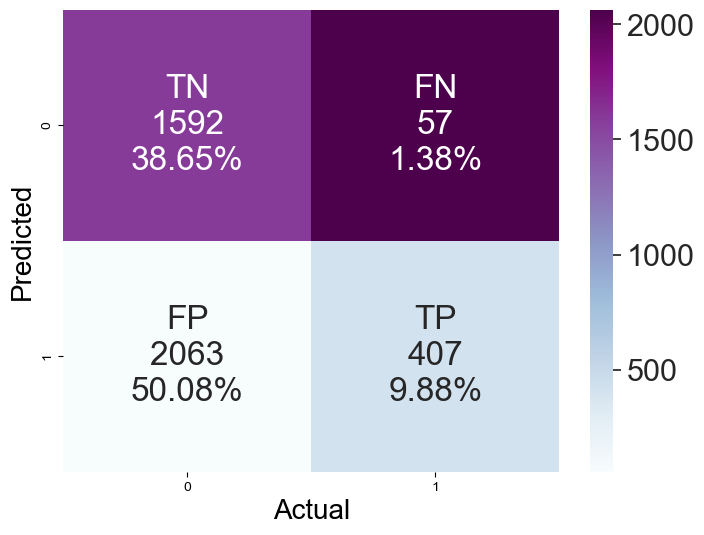

In [37]:
TN, FP, FN, TP = confusion_matrix(test_y, test_y_test_pred).ravel()
fl = [TN, FN, FP, TP]
fig, ax = plt.subplots(figsize=(8, 6))

sns.set(font_scale=2)
group_names = ["TN", "FN", "FP", "TP"]
group_counts = ["{0:0.0f}".format(value) for value in fl]
group_percentages = ["{0:.2%}".format(value) for value in fl / np.sum(cf_matrix)]
labels = [
    f"{v1}\n{v2}\n{v3}"
    for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
]
labels = np.asarray(labels).reshape(2, 2)

sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="BuPu")
plt.ylabel("Predicted", fontsize=20)
plt.xlabel("Actual", fontsize=20)
ax.set_ylim([0, 2])
ax.invert_yaxis()

Although the model manages to avoid predicting worthy calls as useless (low FN) and it reduces the number of useless calls significantly (TN), it at the same time still does recommend to make a lot of useless calls (FP). While Recall is pretty high, other standard metrics, e.g., F1 score and Precision are quite low. Let's try to understand whether the usage of the model is still reasonable and saves company money.

In [41]:
# Profit without using a model = [converted clients] * 80$ - [all clients] * 8$
unique, counts = np.unique(test_y, return_counts=True)
clients_converted = dict(zip(unique, counts))[1]
profit_without_a_model = clients_converted * 80 - len(test_y) * 8
print(f'Profit without using a model: {profit_without_a_model}$')

Profit without using a model: 4168$


In [40]:
# Total gain: [correctly predicted as worthy calls, i.e., TP] * 80$ - [all predicted as worthy calls, i.e., TP + FP] * 8$
# Opportunity costs: [falsely predicted as useless calls, i.e., FN] * (80$ - 8$)
# Clean gain: Total gain - Opportunity costs
profit_with_a_model = TP * 80  - (TP + FP) * 8
opportunity_costs = FN * (80 - 8)
print(f"Total gain with a model: {profit_with_a_model}$")
print(f"Opportunity costs from model usage: {opportunity_costs}$")
print(f"Clean gain with a model: {profit_with_a_model - opportunity_costs}$")

Total gain with a model: 12800$
Opportunity costs from model usage: 4104$
Clean gain with a model: 8696$


Even though the classic performance metrics aren't very high, the model still can help the marketing department gain more profit by reducing the number of useless calls and saving money there. While still suggesting to do some calls that won't lead to conversion, the model makes sure as little business is lost as possible by avoiding false Neagtives through maximizing the Recall and optimizing the threshold. 

For the scope of this project, we save the model and prepare to deploy it into an ML pipeline.

TODO: FEATURE IMPORTANCE